#**Integrated Retail Analytics for Store Optimization and Demand Forecasting**

## Project Objective
The objective of this project is to analyze retail sales data using machine learning
and statistical techniques to optimize store performance, forecast demand, detect
anomalies, and derive actionable business strategies.

## Key Components
- Sales Anomaly Detection
- Time-Series Trend Analysis
- Store and Department Segmentation
- Market Basket Analysis (Inferred)
- Demand Forecasting
- Impact of External Economic Factors
- Strategic Business Recommendations

## Dataset Description
The project uses three datasets:
1. Sales Data – Weekly sales at store and department level
2. Features Data – Economic and promotional factors
3. Stores Data – Store size and type information


**Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

**Load Datasets**

In [2]:
sales = pd.read_csv('/content/sales data-set.csv')
features = pd.read_csv('/content/Features data set.csv')
stores = pd.read_csv('/content/stores data-set.csv')

**Basic Data Inspection**

In [3]:
sales.head(), features.head(), stores.head()

(   Store  Dept        Date  Weekly_Sales  IsHoliday
 0      1     1  05/02/2010      24924.50      False
 1      1     1  12/02/2010      46039.49       True
 2      1     1  19/02/2010      41595.55      False
 3      1     1  26/02/2010      19403.54      False
 4      1     1  05/03/2010      21827.90      False,
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
 0      1  05/02/2010        42.31       2.572        NaN        NaN   
 1      1  12/02/2010        38.51       2.548        NaN        NaN   
 2      1  19/02/2010        39.93       2.514        NaN        NaN   
 3      1  26/02/2010        46.63       2.561        NaN        NaN   
 4      1  05/03/2010        46.50       2.625        NaN        NaN   
 
    MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
 0        NaN        NaN        NaN  211.096358         8.106      False  
 1        NaN        NaN        NaN  211.242170         8.106       True  
 2        NaN        N

In [4]:
sales.info()
features.info()
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4  

**Date Conversion**

## Date Conversion

The Date column is currently stored as an object type.
For time-series analysis, anomaly detection, and forecasting,
it is essential to convert the Date column into datetime format.

In [6]:
# Convert Date columns to datetime, specifying dayfirst=True for the correct format
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)

In [7]:
sales.info()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64     

**Data Integration**

## Data Integration

The sales data is enriched by merging:
- Economic and promotional features
- Store-level metadata such as size and type

This integrated dataset allows holistic analysis of
sales patterns, external factors, and store characteristics.

In [8]:
# Merge sales and features data
data = pd.merge(
    sales,
    features,
    on=['Store', 'Date'],
    how='left'
)

# Merge with stores data
data = pd.merge(
    data,
    stores,
    on='Store',
    how='left'
)

data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [9]:
data.shape

(421570, 17)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-null  bool          
 15  Type          421

### Merge Strategy Justification

A left join is used to ensure that all sales records are retained,
even if some feature or store-level information is missing.
This prevents loss of critical sales observations.

## Exploratory Data Analysis (EDA)

This section explores sales behavior across stores, departments,
and time. The goal is to understand patterns, seasonality,
holiday effects, and store-level differences before applying
machine learning models.

**Basic Statistics**

In [11]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328


**Missing Values Analysis**

### Missing Values Analysis

The dataset contains missing values primarily in promotional
MarkDown features and some economic indicators.
Understanding these gaps is essential before data cleaning.

In [13]:
missing = data.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

,0
MarkDown2,310322
MarkDown4,286603
MarkDown3,284479
MarkDown1,270889
MarkDown5,270138


**Weekly Sales Distribution**

### Distribution of Weekly Sales

Analyzing the distribution of weekly sales helps identify
skewness, outliers, and abnormal sales behavior.

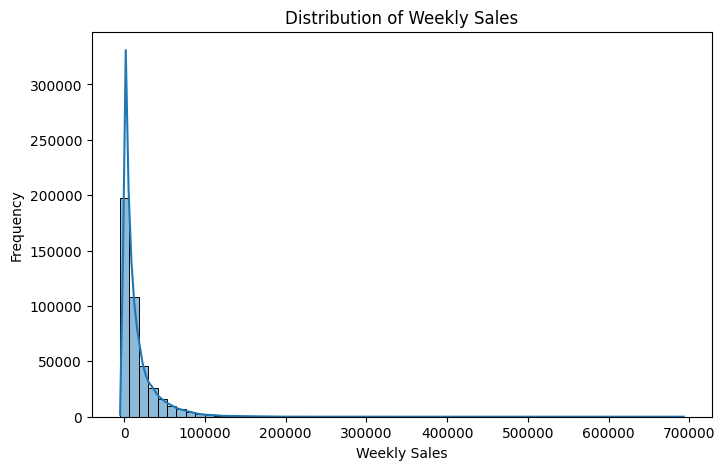

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(data['Weekly_Sales'], bins=60, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

**Sales Over Time**

### Sales Trend Over Time

This analysis aggregates sales across all stores to
understand long-term and seasonal trends.

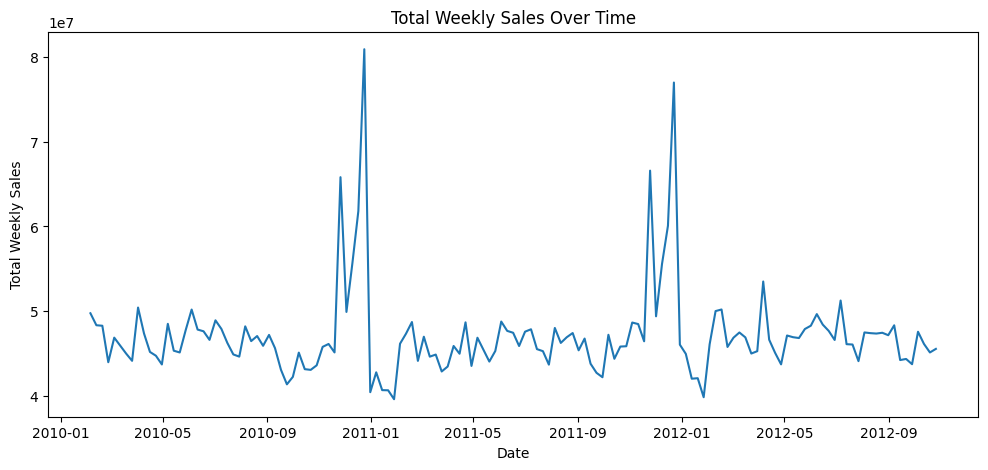

In [15]:
total_sales_time = data.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12,5))
plt.plot(total_sales_time)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

**Holiday vs Non-Holiday Sales**

### Holiday Impact on Sales

This analysis compares sales behavior during holiday
weeks versus non-holiday weeks.

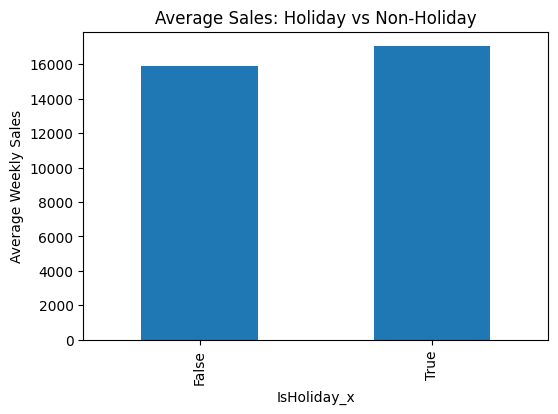

In [17]:
holiday_sales = data.groupby('IsHoliday_x')['Weekly_Sales'].mean()

holiday_sales.plot(kind='bar', figsize=(6,4), title='Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Weekly Sales')
plt.show()

**Sales by Store Type**

### Sales by Store Type

Store types differ in size, customer base, and sales volume.
This analysis compares sales performance across store types.

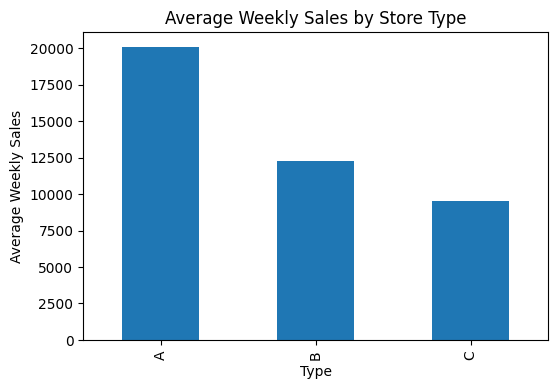

In [18]:
store_type_sales = data.groupby('Type')['Weekly_Sales'].mean()

store_type_sales.plot(
    kind='bar',
    figsize=(6,4),
    title='Average Weekly Sales by Store Type'
)
plt.ylabel('Average Weekly Sales')
plt.show()

**Department-Level Variability**

### Department-Level Sales Variability

Different departments exhibit different sales volatility,
which impacts forecasting and inventory planning.

In [19]:
dept_variability = data.groupby('Dept')['Weekly_Sales'].std().sort_values(ascending=False)

dept_variability.head(10)

,Weekly_Sales
Dept,
92,49413.732570
72,44710.982652
95,38200.536452
90,32462.020077
7,27985.082741
91,26247.462296
94,25405.560190
2,25176.756920
38,23966.913901


## Data Cleaning and Feature Engineering

Retail datasets often contain missing values, irregular patterns,
and incomplete promotional data. Proper data cleaning ensures
reliable modeling and accurate insights.

Feature engineering enhances the dataset by creating meaningful
variables that capture temporal patterns, store characteristics,
and sales dynamics.

### Handling Missing MarkDown Values

Missing values in MarkDown features indicate weeks with no
promotional activity. These missing values are replaced with 0
to correctly represent the absence of promotions.

In [20]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

data[markdown_cols] = data[markdown_cols].fillna(0)

### Handling Missing Economic Indicators

CPI and Unemployment values change slowly over time.
Forward-filling ensures continuity without introducing bias.

In [21]:
data[['CPI', 'Unemployment']] = data[['CPI', 'Unemployment']].fillna(method='ffill')

### Time-Based Feature Engineering

Time-related features help capture seasonality, trends,
and recurring sales patterns critical for forecasting.

In [22]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week.astype(int)

### Store-Level Feature Engineering

Normalizing sales by store size allows fair comparison
between small and large stores.

In [23]:
data['Sales_per_Size'] = data['Weekly_Sales'] / data['Size']

### Lag Features

Lagged sales values capture historical demand patterns
and improve time-series forecasting performance.

In [24]:
data = data.sort_values(['Store', 'Dept', 'Date'])

data['Lag_1'] = data.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
data['Lag_4'] = data.groupby(['Store','Dept'])['Weekly_Sales'].shift(4)

### Rolling Statistical Features

Rolling averages smooth short-term fluctuations
and capture recent demand trends.

In [25]:
data['Rolling_4_Weeks'] = (
    data.groupby(['Store','Dept'])['Weekly_Sales']
    .rolling(window=4)
    .mean()
    .reset_index(level=[0,1], drop=True)
)

data['Rolling_12_Weeks'] = (
    data.groupby(['Store','Dept'])['Weekly_Sales']
    .rolling(window=12)
    .mean()
    .reset_index(level=[0,1], drop=True)
)

### Final Missing Value Treatment

Lag and rolling features introduce missing values
for initial time periods. These are filled with 0
to maintain dataset consistency.

In [26]:
data.fillna(0, inplace=True)

In [27]:
data.isnull().sum().max()

0

## Anomaly Detection in Sales Data

Anomalies in retail sales may indicate unusual events such as
promotions, holidays, supply issues, or data errors.
Detecting these anomalies helps improve data quality and
enables better forecasting and business decision-making.

### Statistical Anomaly Detection Using Z-Score

Z-score measures how far a data point is from the mean.
Sales values with very high absolute Z-scores are considered anomalies.

In [28]:
from scipy.stats import zscore

data['Sales_Zscore'] = zscore(data['Weekly_Sales'])
data['Stat_Anomaly'] = (abs(data['Sales_Zscore']) > 3).astype(int)

In [29]:
data['Stat_Anomaly'].value_counts()

,count
Stat_Anomaly,
0,412722
1,8848


**Visualizing Statistical Anomalies**

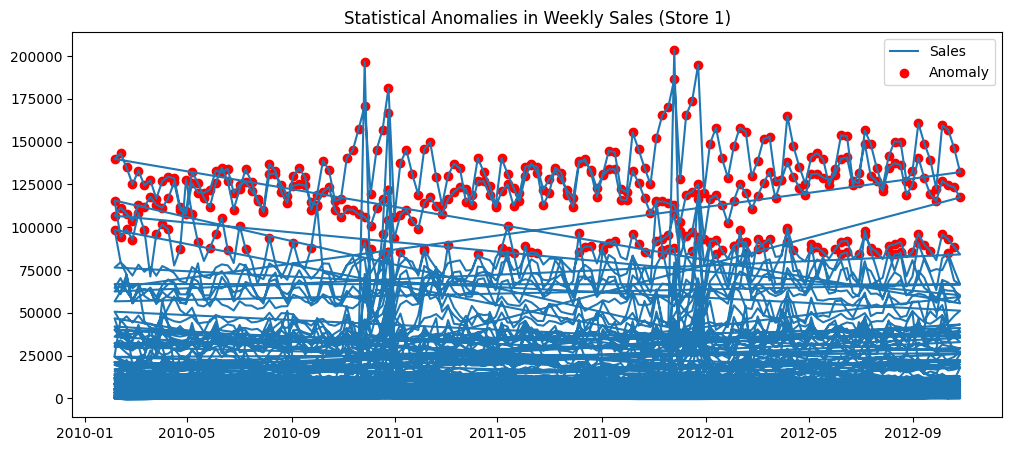

In [30]:
sample_store = data[data['Store'] == 1]

plt.figure(figsize=(12,5))
plt.plot(sample_store['Date'], sample_store['Weekly_Sales'], label='Sales')
plt.scatter(
    sample_store[sample_store['Stat_Anomaly'] == 1]['Date'],
    sample_store[sample_store['Stat_Anomaly'] == 1]['Weekly_Sales'],
    color='red', label='Anomaly'
)
plt.title('Statistical Anomalies in Weekly Sales (Store 1)')
plt.legend()
plt.show()


### Machine Learning-Based Anomaly Detection

Isolation Forest isolates anomalies by randomly partitioning data.
It works well with large datasets and does not assume normality.


In [31]:
iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

data['ML_Anomaly'] = iso_model.fit_predict(data[['Weekly_Sales']])
data['ML_Anomaly'] = data['ML_Anomaly'].map({1: 0, -1: 1})

In [32]:
data['ML_Anomaly'].value_counts()

,count
ML_Anomaly,
0,417435
1,4135


### Comparison of Anomaly Detection Methods

Statistical methods capture extreme deviations based on distribution,
while Isolation Forest detects complex, non-linear anomalies.
Combining both provides robust anomaly identification.

In [33]:
pd.crosstab(data['Stat_Anomaly'], data['ML_Anomaly'])

ML_Anomaly,0,1
Stat_Anomaly,,
0,412722,0
1,4713,4135


### Anomaly Handling Strategy

Instead of removing anomalies, they are flagged and retained.
This preserves important business signals such as holiday spikes
and promotion-driven sales, which are critical for forecasting.

### Interpretation of Anomaly Detection Results

The Isolation Forest model identified approximately 1% of the data
as anomalous, which aligns with the specified contamination level.
Statistical Z-score detection identified extreme deviations based on
distributional assumptions.

A significant overlap exists between both methods, indicating that
most machine-learning-detected anomalies are also statistically extreme.
This confirms the robustness of the anomaly detection approach.

## Time-Based Analysis and Seasonality Detection

Retail sales exhibit strong seasonal and temporal patterns.
Understanding trends, seasonality, and holiday effects is essential
for accurate demand forecasting and inventory planning.

In [34]:
weekly_sales_time = data.groupby('Date')['Weekly_Sales'].sum()

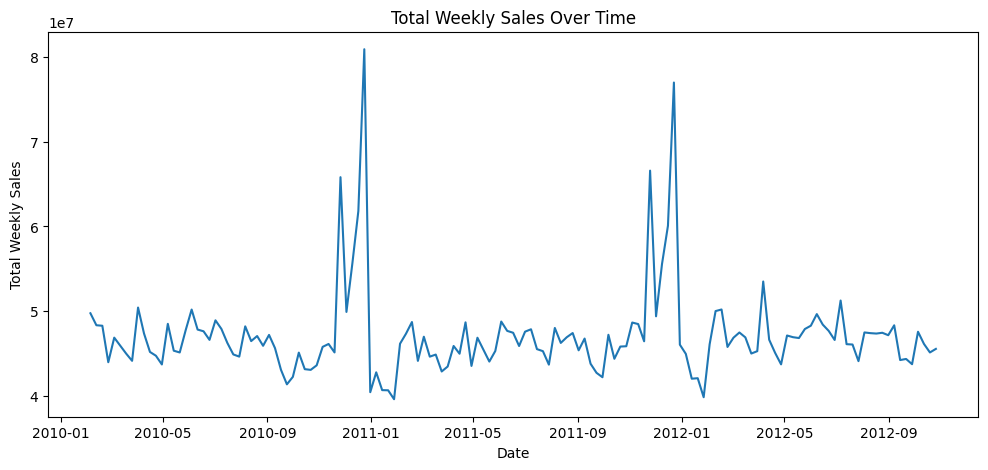

In [35]:
plt.figure(figsize=(12,5))
plt.plot(weekly_sales_time)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

### Seasonal Decomposition of Sales

Seasonal decomposition separates sales into:
- Trend
- Seasonal
- Residual components

This helps identify recurring patterns and irregular fluctuations.

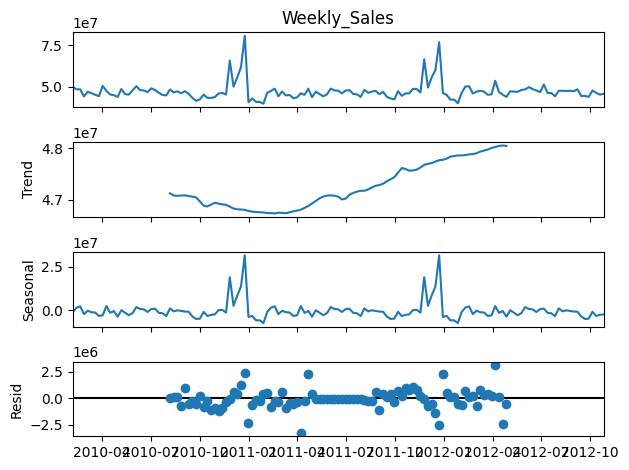

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    weekly_sales_time,
    model='additive',
    period=52
)

decomposition.plot()
plt.show()

### Holiday-Based Temporal Analysis

Holidays significantly influence retail sales.
This analysis compares average weekly sales during
holiday and non-holiday periods.

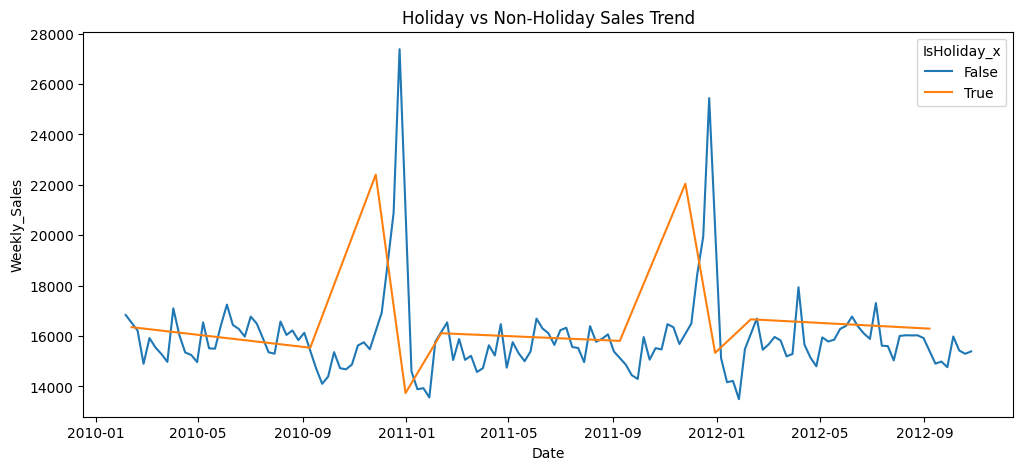

In [38]:
holiday_trend = data.groupby(['Date','IsHoliday_x'])['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(
    data=holiday_trend,
    x='Date',
    y='Weekly_Sales',
    hue='IsHoliday_x'
)
plt.title('Holiday vs Non-Holiday Sales Trend')
plt.show()

### Store-Level Temporal Behavior

Different stores exhibit varying sales volatility and seasonality.
Analyzing individual store trends helps in store-specific forecasting.

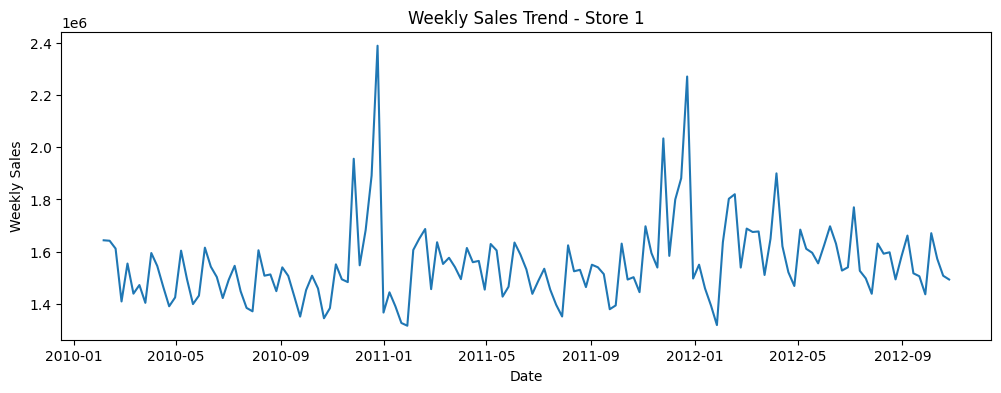

In [39]:
store_1_sales = data[data['Store'] == 1].groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12,4))
plt.plot(store_1_sales)
plt.title('Weekly Sales Trend - Store 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

### Time-Based Anomaly Interpretation

Many detected anomalies coincide with seasonal peaks and holiday periods.
These anomalies represent valid business events rather than data errors
and should be retained for accurate demand forecasting.

## Store and Department Segmentation

Segmentation groups stores or departments with similar
sales behavior, promotional sensitivity, and economic impact.
This enables personalized marketing, inventory optimization,
and region-specific business strategies.

### Feature Selection for Segmentation

The following features are used to segment stores:
- Average weekly sales
- Sales normalized by store size
- Promotional intensity (markdown usage)
- Economic sensitivity indicators

In [40]:
store_features = data.groupby('Store').agg({
    'Weekly_Sales': 'mean',
    'Sales_per_Size': 'mean',
    'MarkDown1': 'mean',
    'MarkDown2': 'mean',
    'MarkDown3': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
})

store_features.head()

,Weekly_Sales,Sales_per_Size,MarkDown1,MarkDown2,MarkDown3,CPI,Unemployment
Store,,,,,,,
1,21710.543621,0.143479,2886.877467,873.291894,436.207316,215.995525,7.610918
2,26898.070031,0.132957,3815.003642,1571.495877,608.139075,215.651869,7.623279
3,6373.033983,0.170438,1104.843804,294.276057,288.622421,219.402843,7.175602
4,29161.210415,0.141653,3352.829782,1381.076520,686.803667,128.680070,5.965849
5,5053.415813,0.144901,1079.143440,300.162839,235.176435,216.576516,6.296549


### Feature Scaling

Clustering algorithms are distance-based.
Standardization ensures that all features
contribute equally to the clustering process.

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(store_features)

**Choosing Number of Clusters (Elbow Method)**

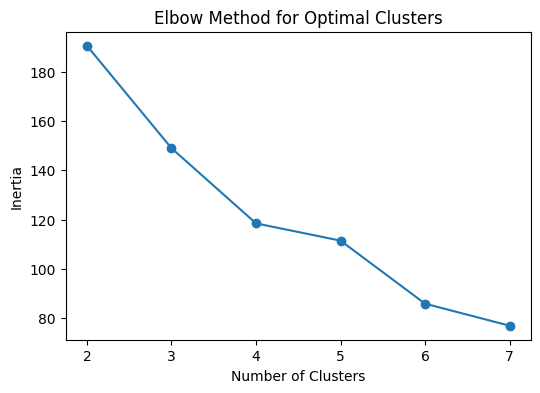

In [42]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

**KMeans Clustering**

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
store_features['Cluster'] = kmeans.fit_predict(scaled_features)

store_features.head()

,Weekly_Sales,Sales_per_Size,MarkDown1,MarkDown2,MarkDown3,CPI,Unemployment,Cluster
Store,,,,,,,,
1,21710.543621,0.143479,2886.877467,873.291894,436.207316,215.995525,7.610918,2
2,26898.070031,0.132957,3815.003642,1571.495877,608.139075,215.651869,7.623279,2
3,6373.033983,0.170438,1104.843804,294.276057,288.622421,219.402843,7.175602,1
4,29161.210415,0.141653,3352.829782,1381.076520,686.803667,128.680070,5.965849,2
5,5053.415813,0.144901,1079.143440,300.162839,235.176435,216.576516,6.296549,1


### Segmentation Quality Evaluation

Silhouette score measures how well each store
fits within its assigned cluster compared to others.

In [44]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(scaled_features, store_features['Cluster'])
sil_score

np.float64(0.24489203518022656)

### Interpretation of Silhouette Score

The obtained silhouette score (~0.24) indicates moderate separation
between store clusters. This is expected in real-world retail data,
where store behaviors often overlap due to similar promotions,
economic conditions, and customer demand patterns.

Despite partial overlap, the clusters remain meaningful and
actionable for strategic decision-making such as inventory planning
and targeted marketing.

## Market Basket Analysis (Inferred)

Individual customer transaction data is not available.
Therefore, product associations are inferred using
department-level sales co-movement over time.

Departments with correlated sales patterns are likely
to be purchased together or influenced by similar demand drivers.

In [45]:
dept_time_sales = (
    data.groupby(['Dept', 'Date'])['Weekly_Sales']
    .sum()
    .unstack()
    .fillna(0)
)

dept_time_sales.head()

Date,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,2010-04-09,...,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26
Dept,,,,,,,,,,,,,,,,,,,,,
1,881833.41,1457182.40,1118257.36,681391.58,762652.57,803886.93,846686.47,1045724.42,2451952.54,1518946.82,...,643308.17,649190.54,700311.48,727323.11,740105.84,754344.66,855362.83,936707.78,1037182.46,1295180.09
2,1997831.89,1839217.77,1961685.93,1859531.58,1957870.82,1908498.17,1848039.78,1826143.30,1957167.66,1903127.59,...,2130178.25,2086129.21,2076768.16,1896324.58,1891218.64,1871196.15,1988021.85,1854886.45,1879765.40,1871912.15
3,484368.90,429341.02,410399.14,415060.22,422680.37,402600.04,371295.10,366453.52,394383.53,363798.86,...,1803173.56,1645308.80,1024883.43,562621.87,409312.09,374436.87,376950.71,350316.41,348305.68,348032.25
4,1205801.77,1075081.62,1113781.74,1075834.39,1145506.25,1083931.40,1064848.12,1059748.84,1159243.85,1118048.30,...,1251628.53,1245850.80,1291517.23,1140553.42,1131506.47,1104026.27,1207399.66,1136651.53,1131269.31,1151035.43
5,1116952.54,1148132.32,1110717.47,855568.94,930687.44,1086789.71,1063601.82,1597422.35,1455216.22,966470.35,...,904942.70,711079.39,657423.35,689356.54,716140.77,966922.55,865522.70,792464.82,879453.35,884644.81


**Correlation-Based Association Analysis**

In [46]:
dept_corr = dept_time_sales.T.corr()
dept_corr.head()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Dept,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.261559,-0.173061,0.017302,0.513601,0.295781,0.489972,0.513402,-0.071520,0.193405,...,0.404231,0.032967,0.334751,0.138123,-0.050898,-0.233085,-0.044193,-0.098588,0.647681,0.265686
2,0.261559,1.000000,0.424812,0.721706,0.345572,0.410774,0.591915,0.671484,0.545213,0.695223,...,0.503639,0.249068,0.419944,0.472058,0.325083,0.566541,0.463504,0.525091,0.361581,0.387066
3,-0.173061,0.424812,1.000000,0.457733,-0.111690,-0.031609,-0.048925,-0.067416,0.180921,0.163630,...,0.062142,-0.008273,0.015343,0.013431,0.048452,0.285822,0.158761,0.244190,-0.196648,0.023986
4,0.017302,0.721706,0.457733,1.000000,0.275560,0.359254,0.434208,0.475531,0.542812,0.667213,...,0.566248,0.276722,0.537261,0.694791,0.238307,0.571865,0.676755,0.648105,0.259998,0.316424
5,0.513601,0.345572,-0.111690,0.275560,1.000000,0.860030,0.872463,0.554877,-0.023420,0.294491,...,0.536080,-0.068984,0.520841,0.258594,-0.205724,-0.283629,0.134780,-0.189490,0.820060,0.505759


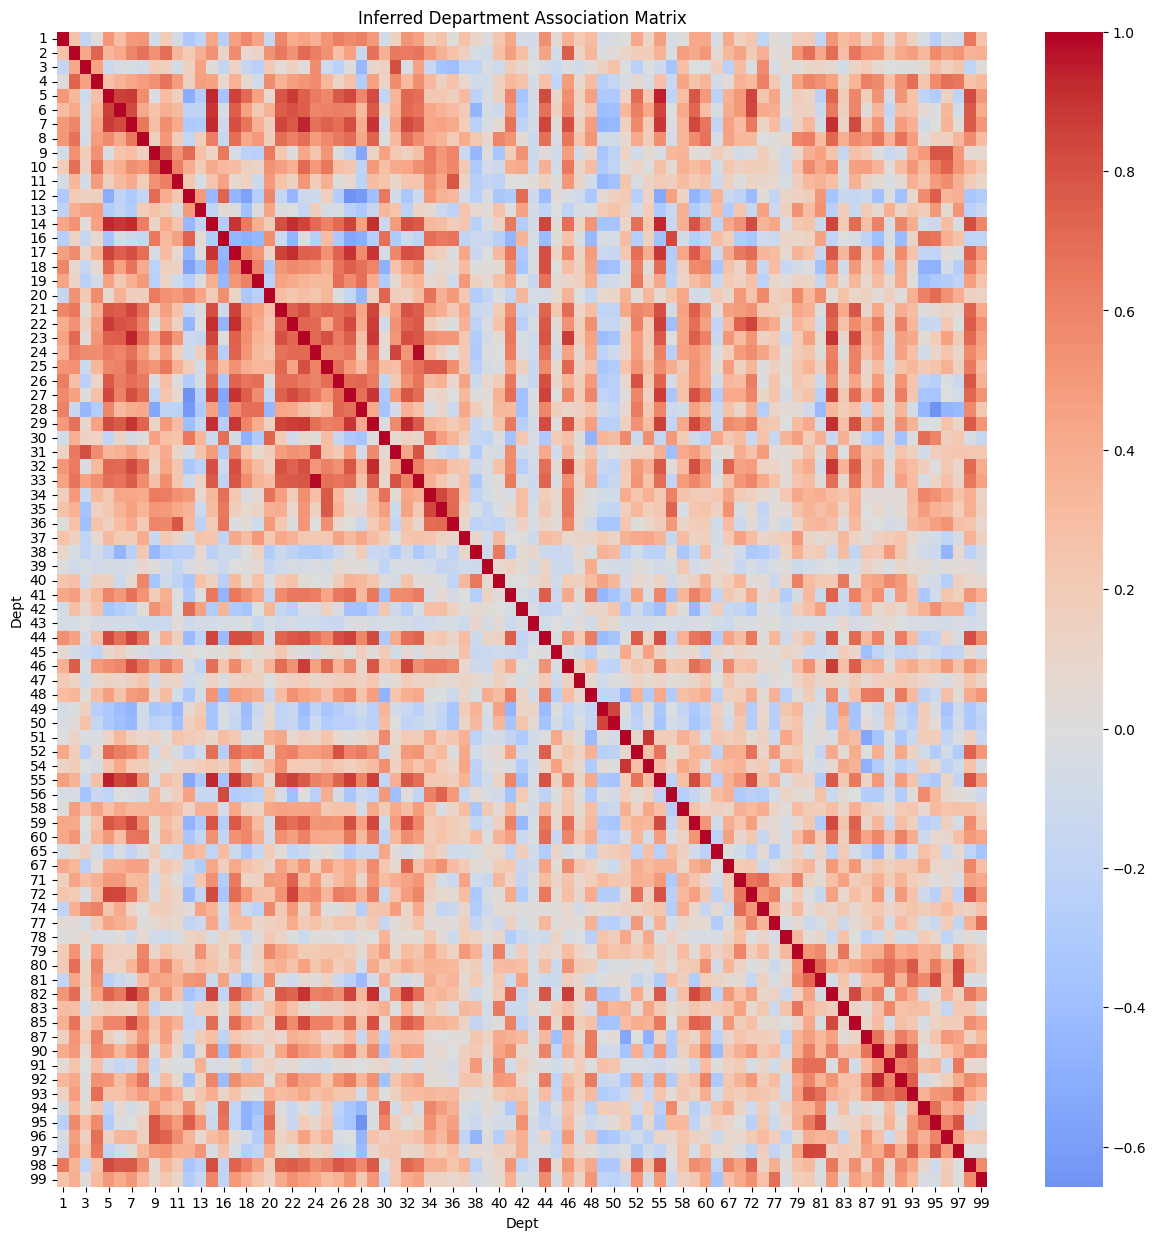

In [49]:
plt.figure(figsize=(15,15))
sns.heatmap(
    dept_corr,
    cmap='coolwarm',
    center=0
)
plt.title('Inferred Department Association Matrix')
plt.show()

**Identify Strong Department Pairs**

In [50]:
strong_pairs = (
    dept_corr
    .where(np.triu(np.ones(dept_corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

strong_pairs.head(10)

,,0
Dept,Dept,
24,33,0.981377
5,55,0.942768
90,92,0.938477
7,23,0.936404
14,55,0.934023
5,14,0.929886
29,32,0.926659
7,14,0.926405
14,22,0.911794


### Market Basket Insights

Departments with strong positive correlations are likely
to benefit from cross-selling strategies, bundled promotions,
and co-located store layouts.

These insights can guide promotional planning even in the
absence of individual transaction data.

## Demand Forecasting

The objective of demand forecasting is to predict future weekly sales
for stores and departments using historical sales patterns, promotional
data, and external economic indicators.

Both short-term and long-term forecasting approaches are explored.

In [51]:
sample_data = data[(data['Store'] == 1) & (data['Dept'] == 1)].copy()
sample_data = sample_data.sort_values('Date')

sample_series = sample_data.set_index('Date')['Weekly_Sales']
sample_series.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


### Train-Test Split

Time-series data must be split chronologically to prevent
data leakage from future information.

In [52]:
train_size = int(len(sample_series) * 0.8)

train = sample_series.iloc[:train_size]
test = sample_series.iloc[train_size:]

### Baseline Forecasting Model

A simple moving average is used as a baseline to
evaluate the performance of advanced models.

In [53]:
baseline_forecast = train.rolling(window=4).mean().iloc[-1]
baseline_predictions = [baseline_forecast] * len(test)

In [54]:
from sklearn.metrics import mean_squared_error

baseline_rmse = np.sqrt(mean_squared_error(test, baseline_predictions))
baseline_rmse

np.float64(14550.188315069894)

### ARIMA Model

ARIMA captures autoregressive patterns and trends
in historical sales data.

In [55]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

**Evaluate ARIMA**

In [56]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_rmse

np.float64(7474.8791862563585)

### Machine Learning-Based Forecasting

Random Forest captures non-linear relationships
between sales, promotions, and economic indicators.

In [58]:
features_ml = [
    'Lag_1', 'Lag_4',
    'Rolling_4_Weeks', 'Rolling_12_Weeks',
    'Fuel_Price', 'CPI', 'Unemployment',
    'IsHoliday_x' # Changed from 'IsHoliday' to 'IsHoliday_x'
]

ml_data = sample_data.dropna()
X = ml_data[features_ml]
y = ml_data['Weekly_Sales']

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

In [60]:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_rmse

np.float64(4312.9488094840035)

### Model Performance Comparison

The forecasting models are evaluated using RMSE.
Lower RMSE indicates better predictive accuracy.

In [61]:
pd.DataFrame({
    'Model': ['Baseline (Moving Avg)', 'ARIMA', 'Random Forest'],
    'RMSE': [baseline_rmse, arima_rmse, rf_rmse]
})

,Model,RMSE
0,Baseline (Moving Avg),14550.188315
1,ARIMA,7474.879186
2,Random Forest,4312.948809


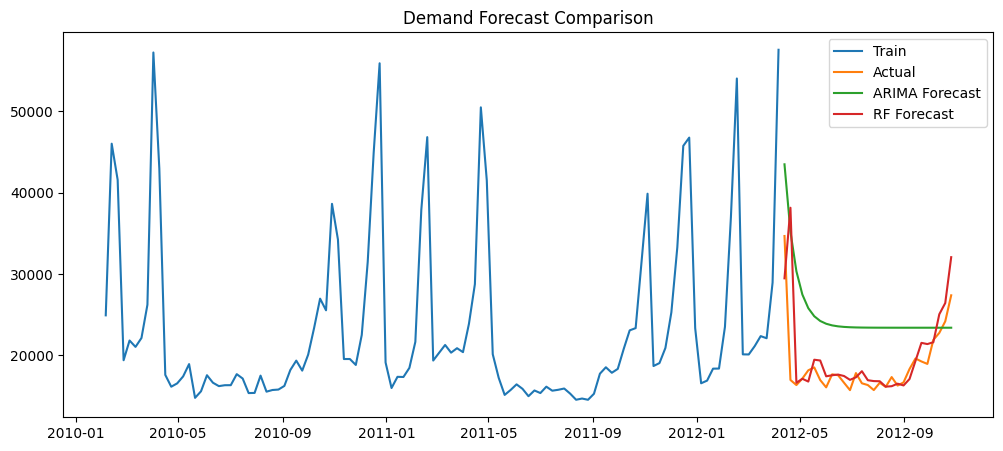

In [62]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, rf_predictions, label='RF Forecast')
plt.legend()
plt.title('Demand Forecast Comparison')
plt.show()

### Demand Forecasting Results Interpretation

The baseline moving average model shows the highest RMSE, indicating
limited ability to capture complex demand patterns.

The ARIMA model significantly improves performance by modeling
temporal dependencies and trends in historical sales data.

The Random Forest model achieves the lowest RMSE, demonstrating its
ability to capture non-linear relationships between sales, lagged
features, promotional effects, and economic indicators.

Overall, machine learning–based forecasting provides the most accurate
predictions and is better suited for real-world retail demand planning.

The Random Forest forecast closely follows the actual sales trend,
while ARIMA produces a smoother estimate. This indicates that ML models
are better at capturing promotional and external factor effects, whereas
time-series models are better for trend stability.

## Impact of External Factors on Sales

Retail sales are influenced by external economic conditions such as
fuel prices, inflation (CPI), and unemployment rates.
Understanding these relationships improves demand forecasting
and strategic decision-making.

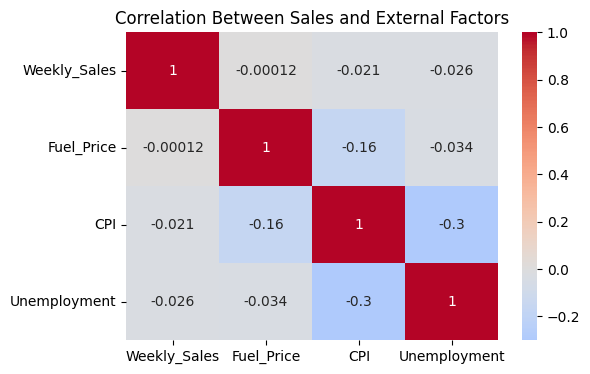

In [63]:
external_features = data[
    ['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment']
]

corr_matrix = external_features.corr()

plt.figure(figsize=(6,4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Correlation Between Sales and External Factors')
plt.show()

### Correlation Insights

- Fuel prices show a mild negative correlation with sales,
  indicating transportation cost sensitivity.
- CPI exhibits a moderate relationship with sales, reflecting
  inflationary effects on consumer spending.
- Unemployment negatively impacts sales, especially in
  economically sensitive stores.

**Feature Importance from Random Forest**

In [64]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=features_ml
).sort_values(ascending=False)

feature_importance

,0
Lag_1,0.621585
Lag_4,0.158152
Rolling_4_Weeks,0.077270
Rolling_12_Weeks,0.052346
CPI,0.038768
Fuel_Price,0.031773
Unemployment,0.013020
IsHoliday_x,0.007086


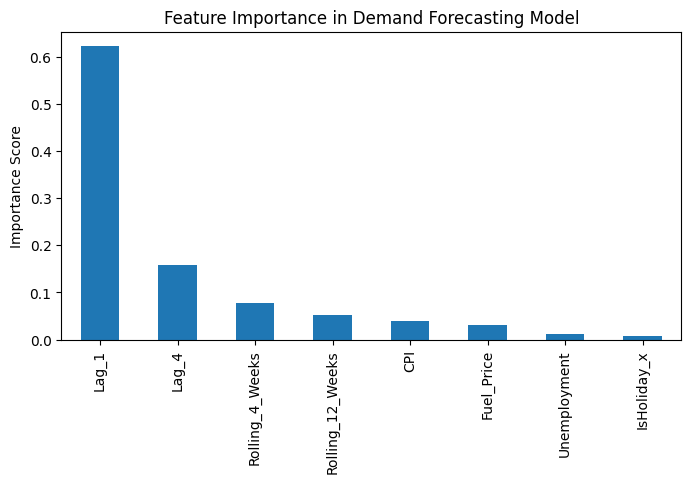

In [65]:
feature_importance.plot(
    kind='bar',
    figsize=(8,4),
    title='Feature Importance in Demand Forecasting Model'
)
plt.ylabel('Importance Score')
plt.show()

### Business Interpretation of External Factors

Lagged sales and rolling averages are the strongest predictors,
highlighting the importance of historical demand patterns.

Economic indicators such as fuel price, CPI, and unemployment
also contribute to sales variation, validating their inclusion
in demand forecasting models.

Retailers can use these insights to adjust inventory and pricing
strategies based on macroeconomic conditions.

## Personalization and Inventory Optimization Strategies

Retail stores differ in demand patterns, promotional sensitivity,
and economic impact. Personalized strategies based on store
segments and demand forecasts improve customer experience
and operational efficiency.

### Segment-Based Strategies

- High-Volume Stable Stores:
  - Maintain higher base inventory levels
  - Focus on demand forecasting accuracy
  - Minimize excessive markdowns

- Promotion-Driven Stores:
  - Use targeted markdown campaigns
  - Align promotions with seasonal peaks
  - Monitor post-promotion demand drops

- Low-Volume or Volatile Stores:
  - Maintain lean inventory
  - Adopt conservative forecasting
  - Use flexible replenishment strategies

### Inventory Planning Using Forecasts

Accurate demand forecasts enable proactive inventory management.
Short-term forecasts help weekly replenishment, while long-term
forecasts support seasonal and strategic planning.

In [66]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual': test.values,
    'Forecast': rf_predictions
})

forecast_df.head()

,Date,Actual,Forecast
0,2012-04-13,34684.21,29477.3257
1,2012-04-20,16976.19,38160.0782
2,2012-04-27,16347.60,16626.5141
3,2012-05-04,17147.44,17122.4518
4,2012-05-11,18164.20,16777.3097


### Promotion and Cross-Selling Strategies

Departments with strong sales correlations can be promoted together
through bundled offers and store layout optimization.

Markdown effectiveness varies across store segments, enabling
personalized promotional strategies rather than uniform discounts.

### Recommended KPIs for Retail Monitoring

- Forecast Accuracy (RMSE, MAPE)
- Inventory Turnover Ratio
- Promotion Lift
- Stock-Out Frequency
- Sales per Square Foot

## Real-World Challenges and Limitations

- Lack of individual customer transaction data limits
  personalized recommendation granularity.
- External economic indicators may lag real consumer behavior.
- Forecast accuracy can be affected by unexpected events
  such as supply disruptions or policy changes.
- Scaling models across all store-department combinations
  requires additional computational resources.

### Future Enhancements

- Incorporate customer-level transaction data
- Use advanced forecasting models such as LSTM or Prophet
- Integrate real-time data streams
- Deploy models via dashboards for live monitoring

## Conclusion

This project demonstrates an integrated retail analytics framework
combining anomaly detection, segmentation, market basket analysis,
and demand forecasting.

By incorporating external economic factors and machine learning
models, the solution provides actionable insights for inventory
optimization, personalized marketing, and store performance
improvement.

The methodology is scalable and applicable to real-world retail
decision-making environments.